In [4]:
import os
from pathlib import Path
import logging
from datetime import datetime

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Set up logging and CSV export directories
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
log_dir = Path("figures/optimizer/logs")
csv_dir = Path("figures/optimizer/csv_exports")
log_dir.mkdir(parents=True, exist_ok=True)
csv_dir.mkdir(parents=True, exist_ok=True)

log_file = log_dir / f"optimizer_analysis_{timestamp}.log"

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler(log_file),
        logging.StreamHandler(),  # Also log to console
    ],
)

logger = logging.getLogger(__name__)
logger.info(f"Starting optimizer performance analysis - Log file: {log_file}")
logger.info(f"CSV exports will be saved to: {csv_dir}")

# Get list of all CSV files in the directory
list_of_commits = list(Path("../../logs/performance/optimizer").glob("*/"))
list_of_commits.sort(key=os.path.getmtime, reverse=True)
list_of_commits = list_of_commits[:1]

# Initialize an empty DataFrame to store combined results
df_latest = pd.DataFrame()

list_of_files = list(Path(list_of_commits[0] / "all").glob("*.csv"))
logger.info(f"Processing {len(list_of_files)} CSV files from {list_of_commits[0]}")

# For each file in this commit
for file_path in list_of_files:
    # Read the CSV file
    temp_df = pd.read_csv(file_path)
    # Append to the main DataFrame
    df_latest = pd.concat([df_latest, temp_df], ignore_index=True)

# Adjust num_workers: subtract 1 if not 0
df_latest["fainder_max_workers"] = df_latest["fainder_max_workers"].apply(
    lambda x: x - 1 if x != 0 else x
)

# Strip whitespace and normalize the category column
df_latest["category"] = df_latest["category"].str.strip()

logger.info(f"Loaded {len(df_latest)} total records")
logger.info(f"Unique categories: {list(df_latest['category'].unique())}")
logger.info(f"Unique fainder modes: {list(df_latest['fainder_mode'].unique())}")

# Check optimizer columns
optimizer_cols = [
    "optimizer_cost_sorting",
    "optimizer_keyword_merging",
    "optimizer_split_up_junctions",
]
for col in optimizer_cols:
    if col in df_latest.columns:
        unique_vals = df_latest[col].unique()
        logger.info(f"{col}: {list(unique_vals)}")
    else:
        logger.warning(f"Column {col} not found in data")

# Save processed data to CSV
processed_data_file = csv_dir / f"processed_data_{timestamp}.csv"
df_latest.to_csv(processed_data_file, index=False)
logger.info(f"Saved processed data to: {processed_data_file}")

os.makedirs("figures/optimizer", exist_ok=True)

# ========================================
# DATA CONSISTENCY CHECKS
# ========================================

logger.info("=== Data Consistency Checks ===")

# Check for results_consistent column
if "results_consistent" in df_latest.columns:
    logger.info("Found results_consistent column")

    # Check results_consistent values
    consistent_values = df_latest["results_consistent"].value_counts()
    logger.info(f"Results consistency distribution: {dict(consistent_values)}")

    # Check inconsistent results
    inconsistent_records = df_latest[df_latest["results_consistent"] == False]
    if not inconsistent_records.empty:
        logger.warning(
            f"Found {len(inconsistent_records)} records with inconsistent results"
        )

        # Group inconsistent records by category and scenario
        inconsistent_summary = (
            inconsistent_records.groupby(["category", "fainder_mode", "scenario"])
            .size()
            .reset_index(name="count")
        )
        logger.warning("Inconsistent results breakdown:")
        for _, row in inconsistent_summary.iterrows():
            logger.warning(
                f"  {row['category']} - {row['fainder_mode']} - {row['scenario']}: {row['count']} records"
            )

        # Save inconsistent records for further analysis
        inconsistent_file = csv_dir / f"inconsistent_results_{timestamp}.csv"
        inconsistent_records.to_csv(inconsistent_file, index=False)
        logger.info(f"Saved inconsistent records to: {inconsistent_file}")
    else:
        logger.info("All results are consistent")

    # Filter out inconsistent results for analysis
    df_consistent = df_latest[df_latest["results_consistent"] == True]
    logger.info(
        f"Using {len(df_consistent)} consistent records for analysis (filtered out {len(df_latest) - len(df_consistent)} inconsistent records)"
    )
    df_latest = df_consistent
else:
    logger.warning("results_consistent column not found - proceeding with all data")

# Check for complete optimizer combinations
expected_optimizer_combinations = []
for cost_sorting in [True, False]:
    for keyword_merging in [True, False]:
        for split_junctions in [True, False]:
            expected_optimizer_combinations.append(
                {
                    "optimizer_cost_sorting": cost_sorting,
                    "optimizer_keyword_merging": keyword_merging,
                    "optimizer_split_up_junctions": split_junctions,
                }
            )

logger.info(f"Expected {len(expected_optimizer_combinations)} optimizer combinations")

# Check consistency for each category and fainder_mode
consistency_issues = []
for category in df_latest["category"].unique():
    for fainder_mode in df_latest["fainder_mode"].unique():
        df_subset = df_latest[
            (df_latest["category"] == category)
            & (df_latest["fainder_mode"] == fainder_mode)
        ]

        if df_subset.empty:
            continue

        # Check scenarios consistency across optimizer combinations
        scenarios_per_optimizer = {}
        for _, combo in enumerate(expected_optimizer_combinations):
            df_combo = df_subset[
                (df_subset["optimizer_cost_sorting"] == combo["optimizer_cost_sorting"])
                & (
                    df_subset["optimizer_keyword_merging"]
                    == combo["optimizer_keyword_merging"]
                )
                & (
                    df_subset["optimizer_split_up_junctions"]
                    == combo["optimizer_split_up_junctions"]
                )
            ]

            if not df_combo.empty:
                scenarios = set(df_combo["scenario"].unique())
                scenarios_per_optimizer[str(combo)] = scenarios

        # Check if all optimizer combinations have the same scenarios
        if scenarios_per_optimizer:
            reference_scenarios = list(scenarios_per_optimizer.values())[0]
            for combo_str, scenarios in scenarios_per_optimizer.items():
                if scenarios != reference_scenarios:
                    missing_scenarios = reference_scenarios - scenarios
                    extra_scenarios = scenarios - reference_scenarios

                    issue = {
                        "category": category,
                        "fainder_mode": fainder_mode,
                        "optimizer_combo": combo_str,
                        "missing_scenarios": list(missing_scenarios),
                        "extra_scenarios": list(extra_scenarios),
                    }
                    consistency_issues.append(issue)

# Log consistency issues
if consistency_issues:
    logger.warning(f"Found {len(consistency_issues)} scenario consistency issues:")
    for issue in consistency_issues:
        logger.warning(
            f"  {issue['category']} - {issue['fainder_mode']} - {issue['optimizer_combo']}"
        )
        if issue["missing_scenarios"]:
            logger.warning(f"    Missing scenarios: {issue['missing_scenarios']}")
        if issue["extra_scenarios"]:
            logger.warning(f"    Extra scenarios: {issue['extra_scenarios']}")
else:
    logger.info("All optimizer combinations have consistent scenarios")

# Check for duplicate entries (duplicates are expected for multiple test runs)
duplicates = df_latest.duplicated(
    subset=[
        "category",
        "fainder_mode",
        "scenario",
        "optimizer_cost_sorting",
        "optimizer_keyword_merging",
        "optimizer_split_up_junctions",
    ]
)
if duplicates.any():
    num_duplicates = duplicates.sum()
    logger.info(
        f"Found {num_duplicates} duplicate entries (expected for multiple test runs)"
    )

    # Show distribution of duplicates by configuration
    duplicate_configs = (
        df_latest[duplicates]
        .groupby(
            [
                "category",
                "fainder_mode",
                "scenario",
                "optimizer_cost_sorting",
                "optimizer_keyword_merging",
                "optimizer_split_up_junctions",
            ]
        )
        .size()
        .reset_index(name="duplicate_count")
    )

    logger.info(
        f"Duplicate distribution: {duplicate_configs['duplicate_count'].describe()}"
    )
    logger.info(
        f"Average duplicates per configuration: {duplicate_configs['duplicate_count'].mean():.1f}"
    )
else:
    logger.info("No duplicate entries found")

# Save consistency report
if consistency_issues:
    consistency_df = pd.DataFrame(consistency_issues)
    consistency_file = csv_dir / f"scenario_consistency_issues_{timestamp}.csv"
    consistency_df.to_csv(consistency_file, index=False)
    logger.info(f"Saved scenario consistency issues to: {consistency_file}")

print("Data loaded successfully!")
print(f"Shape: {df_latest.shape}")
print("Optimizer columns available:")
for col in optimizer_cols:
    if col in df_latest.columns:
        print(f"  {col}: {df_latest[col].unique()}")

2025-07-19 18:32:28,936 - INFO - Starting optimizer performance analysis - Log file: figures/optimizer/logs/optimizer_analysis_20250719_183228.log
2025-07-19 18:32:28,937 - INFO - CSV exports will be saved to: figures/optimizer/csv_exports
2025-07-19 18:32:28,938 - INFO - Processing 4 CSV files from ../../logs/performance/optimizer/test
2025-07-19 18:32:28,999 - INFO - Loaded 18560 total records
2025-07-19 18:32:29,000 - INFO - Unique categories: ['base_keyword_queries', 'base_keyword_queries_with_multiple_elements', 'base_column_name_queries', 'base_percentile_queries', 'Percentile_Combinations', 'Multiple_Percentile_Combinations', 'Expected_Form', 'Expected_Form_Extended', 'Multiple_percentile_combinations_with_Keyword', 'Double_expected_Form', 'Early_exit_Results', 'Middle_exit_Results', 'NOT_Combinations']
2025-07-19 18:32:29,001 - INFO - Unique fainder modes: ['full_precision', 'exact']
2025-07-19 18:32:29,002 - INFO - optimizer_cost_sorting: [np.True_, np.False_]
2025-07-19 18:32

Data loaded successfully!
Shape: (18560, 20)
Optimizer columns available:
  optimizer_cost_sorting: [ True False]
  optimizer_keyword_merging: [ True False]
  optimizer_split_up_junctions: [ True False]


2025-07-19 18:32:29,252 - INFO - === Keyword Merging Optimization Analysis ===
2025-07-19 18:32:29,255 - INFO - Found 40 records for keyword merging-related categories
2025-07-19 18:32:29,256 - INFO - After filtering for all other optimizers ON: 40 records
2025-07-19 18:32:29,256 - INFO - Analyzing category: base_keyword_queries_with_multiple_elements (40 records)
2025-07-19 18:32:29,273 - INFO - Saved keyword merging statistics to: figures/optimizer/csv_exports/keyword_merging_stats_20250719_183228.csv


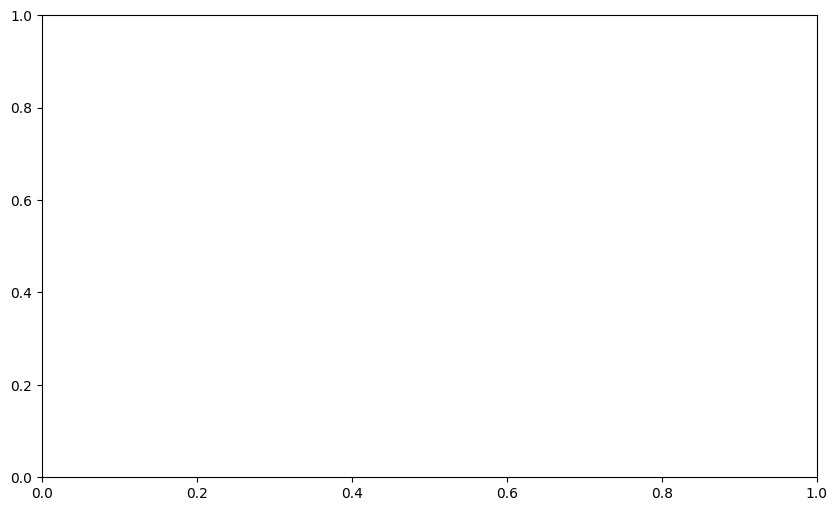

In [5]:
# ========================================
# KEYWORD MERGING OPTIMIZATION ANALYSIS
# ========================================

logger.info("=== Keyword Merging Optimization Analysis ===")

# Filter for categories that benefit from keyword merging
keyword_categories = ["base_keyword_queries_with_multiple_elements"]

# Check if optimizer_keyword_merging column exists
if "optimizer_keyword_merging" not in df_latest.columns:
    logger.warning(
        "optimizer_keyword_merging column not found in data - skipping keyword merging analysis"
    )
else:
    keyword_merging_stats = []

    # Filter data for keyword-related categories
    df_keywords = df_latest[df_latest["category"].isin(keyword_categories)]
    logger.info(
        f"Found {len(df_keywords)} records for keyword merging-related categories"
    )

    # FILTER: Only include data where all other optimizers are turned ON
    df_keywords_filtered = df_keywords[
        (df_keywords["optimizer_cost_sorting"] == True)
        & (df_keywords["optimizer_split_up_junctions"] == True)
    ]
    logger.info(
        f"After filtering for all other optimizers ON: {len(df_keywords_filtered)} records"
    )

    if not df_keywords_filtered.empty:
        # Group by optimizer setting and scenario (ignoring fainder_mode)
        for category in keyword_categories:
            df_cat = df_keywords_filtered[df_keywords_filtered["category"] == category]
            if df_cat.empty:
                continue

            logger.info(f"Analyzing category: {category} ({len(df_cat)} records)")

            # Group by optimizer setting and scenario across all fainder modes
            comparison_data = []

            for kw_merging in df_cat["optimizer_keyword_merging"].unique():
                df_opt = df_cat[df_cat["optimizer_keyword_merging"] == kw_merging]

                for scenario in df_opt["scenario"].unique():
                    df_scenario = df_opt[df_opt["scenario"] == scenario]

                    if not df_scenario.empty:
                        mean_time = df_scenario["execution_time"].mean()
                        std_time = df_scenario["execution_time"].std()
                        min_time = df_scenario["execution_time"].min()
                        max_time = df_scenario["execution_time"].max()
                        count = len(df_scenario)

                        comparison_data.append(
                            {
                                "category": category,
                                "optimizer_keyword_merging": kw_merging,
                                "scenario": scenario,
                                "mean_execution_time": mean_time,
                                "std_execution_time": std_time,
                                "min_execution_time": min_time,
                                "max_execution_time": max_time,
                                "count": count,
                            }
                        )

                        keyword_merging_stats.append(
                            {
                                "category": category,
                                "optimizer_keyword_merging": kw_merging,
                                "scenario": scenario,
                                "mean": mean_time,
                                "std": std_time,
                                "min": min_time,
                                "max": max_time,
                                "count": count,
                            }
                        )

            if comparison_data:
                comparison_df = pd.DataFrame(comparison_data)

                # Create comparison plot
                fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))

                # Create grouped bar plot
                scenarios = comparison_df["scenario"].unique()
                x = np.arange(len(scenarios))
                width = 0.35

                opt_on = comparison_df[
                    comparison_df["optimizer_keyword_merging"] == True
                ]
                opt_off = comparison_df[
                    comparison_df["optimizer_keyword_merging"] == False
                ]

                if not opt_on.empty and not opt_off.empty:
                    # Align data by scenario
                    on_means = [
                        opt_on[opt_on["scenario"] == s]["mean_execution_time"].iloc[0]
                        if not opt_on[opt_on["scenario"] == s].empty
                        else 0
                        for s in scenarios
                    ]
                    off_means = [
                        opt_off[opt_off["scenario"] == s]["mean_execution_time"].iloc[0]
                        if not opt_off[opt_off["scenario"] == s].empty
                        else 0
                        for s in scenarios
                    ]

                    # Get min and max values for error bars
                    off_mins = [
                        opt_off[opt_off["scenario"] == s]["min_execution_time"].iloc[0]
                        if not opt_off[opt_off["scenario"] == s].empty
                        else 0
                        for s in scenarios
                    ]
                    off_maxs = [
                        opt_off[opt_off["scenario"] == s]["max_execution_time"].iloc[0]
                        if not opt_off[opt_off["scenario"] == s].empty
                        else 0
                        for s in scenarios
                    ]
                    on_mins = [
                        opt_on[opt_on["scenario"] == s]["min_execution_time"].iloc[0]
                        if not opt_on[opt_on["scenario"] == s].empty
                        else 0
                        for s in scenarios
                    ]
                    on_maxs = [
                        opt_on[opt_on["scenario"] == s]["max_execution_time"].iloc[0]
                        if not opt_on[opt_on["scenario"] == s].empty
                        else 0
                        for s in scenarios
                    ]

                    # Calculate error bar arrays (lower_error, upper_error)
                    off_lower_err = [
                        mean - min_val for mean, min_val in zip(off_means, off_mins)
                    ]
                    off_upper_err = [
                        max_val - mean for mean, max_val in zip(off_means, off_maxs)
                    ]
                    on_lower_err = [
                        mean - min_val for mean, min_val in zip(on_means, on_mins)
                    ]
                    on_upper_err = [
                        max_val - mean for mean, max_val in zip(on_means, on_maxs)
                    ]

                    ax1.bar(
                        x - width / 2,
                        off_means,
                        width,
                        label="Keyword Merging OFF (others ON)",
                        alpha=0.8,
                        yerr=[off_lower_err, off_upper_err],
                        capsize=5,
                        color="lightcoral",
                    )
                    ax1.bar(
                        x + width / 2,
                        on_means,
                        width,
                        label="All Optimizers ON",
                        alpha=0.8,
                        yerr=[on_lower_err, on_upper_err],
                        capsize=5,
                        color="lightblue",
                    )

                    ax1.set_xlabel("Scenario")
                    ax1.set_ylabel("Execution Time (s)")
                    ax1.set_xticks(x)
                    ax1.set_xticklabels(scenarios, rotation=45, ha="right")
                    ax1.legend()

                    # Add percentage improvement annotations above bars
                    for i, scenario in enumerate(scenarios):
                        if on_means[i] > 0 and off_means[i] > 0:
                            improvement = (
                                (off_means[i] - on_means[i]) / off_means[i]
                            ) * 100
                            y_pos = (
                                max(off_means[i], on_means[i])
                                + max(off_upper_err[i], on_upper_err[i])
                                + 0.05
                            )
                            ax1.annotate(
                                f"{improvement:.1f}%",
                                xy=(x[i], y_pos),
                                xytext=(0, 3),
                                textcoords="offset points",
                                ha="center",
                                fontsize=9,
                                bbox=dict(
                                    boxstyle="round,pad=0.3", fc="white", alpha=0.8
                                ),
                            )
                            logger.info(
                                f"    {scenario}: {improvement:.2f}% improvement when keyword merging ON"
                            )

                    plt.tight_layout()
                    filename = f"figures/optimizer/keyword_merging_{category}.png"
                    plt.savefig(filename)
                    logger.info(f"    Saved plot: {filename}")
                    plt.show()
    else:
        logger.warning(
            "No data available for keyword merging analysis with all other optimizers ON"
        )

    # Save keyword merging statistics
    if keyword_merging_stats:
        kw_stats_df = pd.DataFrame(keyword_merging_stats)
        kw_stats_file = csv_dir / f"keyword_merging_stats_{timestamp}.csv"
        kw_stats_df.to_csv(kw_stats_file, index=False)
        logger.info(f"Saved keyword merging statistics to: {kw_stats_file}")

2025-07-19 18:32:29,354 - INFO - === Cost Sorting Optimization Analysis ===
2025-07-19 18:32:29,357 - INFO - Found 2800 records for cost sorting-related categories
2025-07-19 18:32:29,359 - INFO - After filtering for all other optimizers ON: 1600 records
2025-07-19 18:32:29,360 - INFO - Analyzing category: Multiple_Percentile_Combinations (1600 records)
2025-07-19 18:32:29,361 - INFO -   Fainder mode: full_precision (800 records)
2025-07-19 18:32:29,388 - INFO -     sequential: 14.60% improvement when cost sorting ON
2025-07-19 18:32:29,389 - INFO -     perfiltering: -292.81% improvement when cost sorting ON
2025-07-19 18:32:29,389 - INFO -     threaded: 23.33% improvement when cost sorting ON
2025-07-19 18:32:29,390 - INFO -     threaded_prefiltering: 26.92% improvement when cost sorting ON
2025-07-19 18:32:29,482 - INFO -     Saved plot: figures/optimizer/cost_sorting_Multiple_Percentile_Combinations_full_precision.png


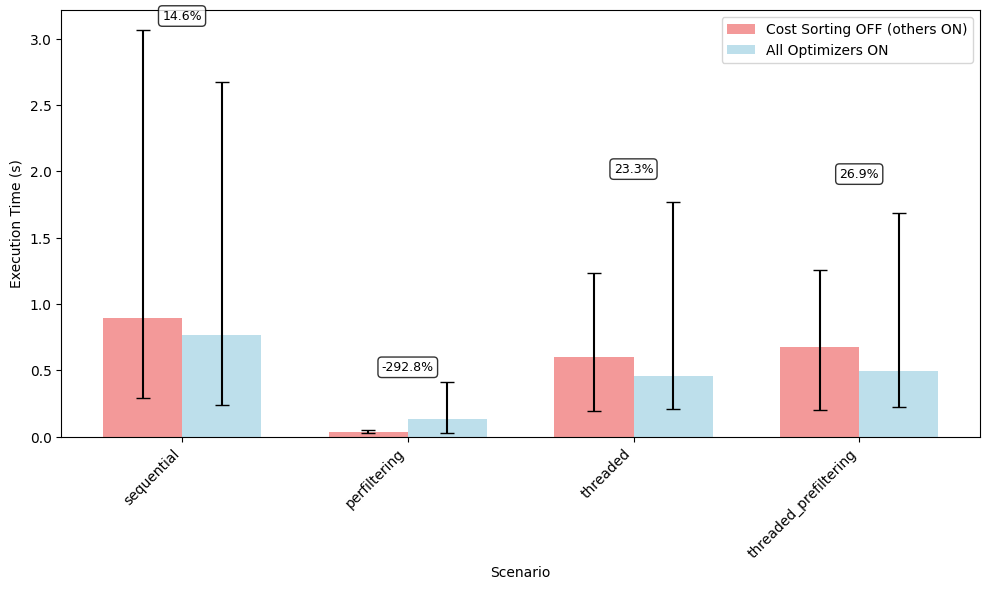

2025-07-19 18:32:29,543 - INFO -   Fainder mode: exact (800 records)
2025-07-19 18:32:29,570 - INFO -     sequential: 10.98% improvement when cost sorting ON
2025-07-19 18:32:29,570 - INFO -     perfiltering: 2.05% improvement when cost sorting ON
2025-07-19 18:32:29,571 - INFO -     threaded: 7.71% improvement when cost sorting ON
2025-07-19 18:32:29,571 - INFO -     threaded_prefiltering: 7.64% improvement when cost sorting ON
2025-07-19 18:32:29,652 - INFO -     Saved plot: figures/optimizer/cost_sorting_Multiple_Percentile_Combinations_exact.png


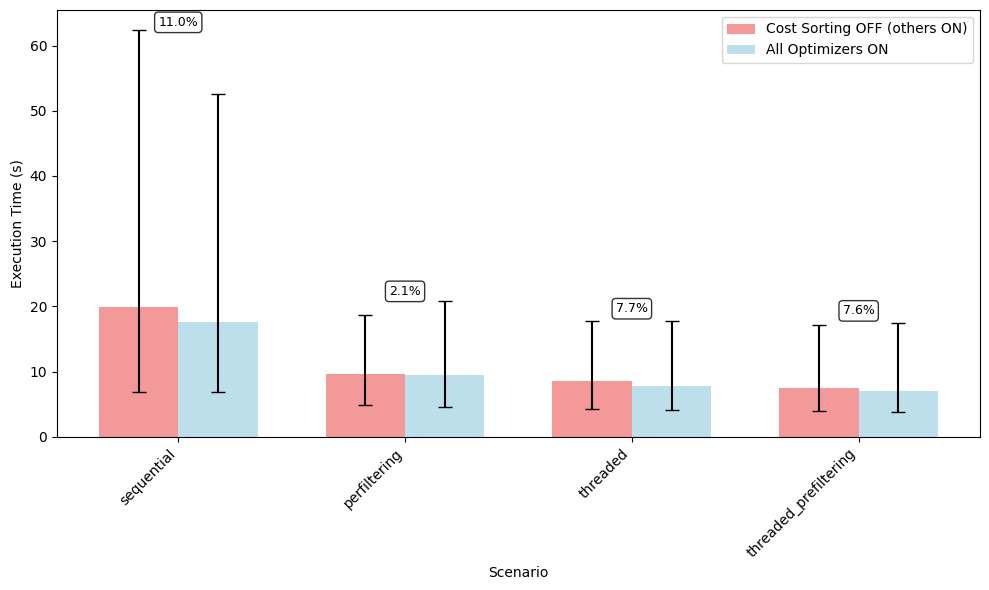

2025-07-19 18:32:29,712 - INFO - Saved cost sorting statistics to: figures/optimizer/csv_exports/cost_sorting_stats_20250719_183228.csv


In [6]:
# ========================================
# COST SORTING OPTIMIZATION ANALYSIS
# ========================================

logger.info("=== Cost Sorting Optimization Analysis ===")

# Filter for categories that involve multiple percentile combinations
cost_sorting_categories = [
    "Multiple_Percentile_Combinations",
]

# Check if optimizer_cost_sorting column exists
if "optimizer_cost_sorting" not in df_latest.columns:
    logger.warning(
        "optimizer_cost_sorting column not found in data - skipping cost sorting analysis"
    )
else:
    cost_sorting_stats = []

    # Filter data for percentile-related categories
    df_cost_sorting = df_latest[df_latest["category"].isin(cost_sorting_categories)]
    logger.info(
        f"Found {len(df_cost_sorting)} records for cost sorting-related categories"
    )

    # FILTER: Only include data where all other optimizers are turned ON
    df_cost_sorting_filtered = df_cost_sorting[
        (df_cost_sorting["optimizer_keyword_merging"] == True)
        & (df_cost_sorting["optimizer_split_up_junctions"] == True)
    ]
    logger.info(
        f"After filtering for all other optimizers ON: {len(df_cost_sorting_filtered)} records"
    )

    if not df_cost_sorting_filtered.empty:
        # Create comprehensive comparison
        for category in cost_sorting_categories:
            df_cat = df_cost_sorting_filtered[
                df_cost_sorting_filtered["category"] == category
            ]
            if df_cat.empty:
                continue

            logger.info(f"Analyzing category: {category} ({len(df_cat)} records)")

            # Create comparison plot for each fainder_mode
            for fainder_mode in df_cat["fainder_mode"].unique():
                df_mode = df_cat[df_cat["fainder_mode"] == fainder_mode]
                if df_mode.empty:
                    continue

                logger.info(f"  Fainder mode: {fainder_mode} ({len(df_mode)} records)")

                # Group by optimizer setting and scenario (assuming same number of workers)
                comparison_data = []

                for cost_sorting in df_mode["optimizer_cost_sorting"].unique():
                    df_opt = df_mode[df_mode["optimizer_cost_sorting"] == cost_sorting]

                    for scenario in df_opt["scenario"].unique():
                        df_scenario = df_opt[df_opt["scenario"] == scenario]

                        if not df_scenario.empty:
                            mean_time = df_scenario["execution_time"].mean()
                            std_time = df_scenario["execution_time"].std()
                            min_time = df_scenario["execution_time"].min()
                            max_time = df_scenario["execution_time"].max()
                            count = len(df_scenario)

                            comparison_data.append(
                                {
                                    "category": category,
                                    "fainder_mode": fainder_mode,
                                    "optimizer_cost_sorting": cost_sorting,
                                    "scenario": scenario,
                                    "mean_execution_time": mean_time,
                                    "std_execution_time": std_time,
                                    "min_execution_time": min_time,
                                    "max_execution_time": max_time,
                                    "count": count,
                                }
                            )

                            cost_sorting_stats.append(
                                {
                                    "category": category,
                                    "fainder_mode": fainder_mode,
                                    "optimizer_cost_sorting": cost_sorting,
                                    "scenario": scenario,
                                    "mean": mean_time,
                                    "std": std_time,
                                    "min": min_time,
                                    "max": max_time,
                                    "count": count,
                                }
                            )

                if comparison_data:
                    comparison_df = pd.DataFrame(comparison_data)

                    # Create comparison plot
                    fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))

                    # Create grouped bar plot
                    scenarios = comparison_df["scenario"].unique()
                    x = np.arange(len(scenarios))
                    width = 0.35

                    opt_on = comparison_df[
                        comparison_df["optimizer_cost_sorting"] == True
                    ]
                    opt_off = comparison_df[
                        comparison_df["optimizer_cost_sorting"] == False
                    ]

                    if not opt_on.empty and not opt_off.empty:
                        # Align data by scenario
                        on_means = [
                            opt_on[opt_on["scenario"] == s]["mean_execution_time"].iloc[
                                0
                            ]
                            if not opt_on[opt_on["scenario"] == s].empty
                            else 0
                            for s in scenarios
                        ]
                        off_means = [
                            opt_off[opt_off["scenario"] == s][
                                "mean_execution_time"
                            ].iloc[0]
                            if not opt_off[opt_off["scenario"] == s].empty
                            else 0
                            for s in scenarios
                        ]

                        # Get min and max values for error bars
                        off_mins = [
                            opt_off[opt_off["scenario"] == s][
                                "min_execution_time"
                            ].iloc[0]
                            if not opt_off[opt_off["scenario"] == s].empty
                            else 0
                            for s in scenarios
                        ]
                        off_maxs = [
                            opt_off[opt_off["scenario"] == s][
                                "max_execution_time"
                            ].iloc[0]
                            if not opt_off[opt_off["scenario"] == s].empty
                            else 0
                            for s in scenarios
                        ]
                        on_mins = [
                            opt_on[opt_on["scenario"] == s]["min_execution_time"].iloc[
                                0
                            ]
                            if not opt_on[opt_on["scenario"] == s].empty
                            else 0
                            for s in scenarios
                        ]
                        on_maxs = [
                            opt_on[opt_on["scenario"] == s]["max_execution_time"].iloc[
                                0
                            ]
                            if not opt_on[opt_on["scenario"] == s].empty
                            else 0
                            for s in scenarios
                        ]

                        # Calculate error bar arrays (lower_error, upper_error)
                        off_lower_err = [
                            mean - min_val for mean, min_val in zip(off_means, off_mins)
                        ]
                        off_upper_err = [
                            max_val - mean for mean, max_val in zip(off_means, off_maxs)
                        ]
                        on_lower_err = [
                            mean - min_val for mean, min_val in zip(on_means, on_mins)
                        ]
                        on_upper_err = [
                            max_val - mean for mean, max_val in zip(on_means, on_maxs)
                        ]

                        ax1.bar(
                            x - width / 2,
                            off_means,
                            width,
                            label="Cost Sorting OFF (others ON)",
                            alpha=0.8,
                            yerr=[off_lower_err, off_upper_err],
                            capsize=5,
                            color="lightcoral",
                        )
                        ax1.bar(
                            x + width / 2,
                            on_means,
                            width,
                            label="All Optimizers ON",
                            alpha=0.8,
                            yerr=[on_lower_err, on_upper_err],
                            capsize=5,
                            color="lightblue",
                        )

                        ax1.set_xlabel("Scenario")
                        ax1.set_ylabel("Execution Time (s)")
                        ax1.set_xticks(x)
                        ax1.set_xticklabels(scenarios, rotation=45, ha="right")
                        ax1.legend()

                        # Add percentage improvement annotations above bars
                        for i, scenario in enumerate(scenarios):
                            if on_means[i] > 0 and off_means[i] > 0:
                                improvement = (
                                    (off_means[i] - on_means[i]) / off_means[i]
                                ) * 100
                                y_pos = (
                                    max(off_means[i], on_means[i])
                                    + max(off_upper_err[i], on_upper_err[i])
                                    + 0.05
                                )
                                ax1.annotate(
                                    f"{improvement:.1f}%",
                                    xy=(x[i], y_pos),
                                    xytext=(0, 3),
                                    textcoords="offset points",
                                    ha="center",
                                    fontsize=9,
                                    bbox=dict(
                                        boxstyle="round,pad=0.3", fc="white", alpha=0.8
                                    ),
                                )
                                logger.info(
                                    f"    {scenario}: {improvement:.2f}% improvement when cost sorting ON"
                                )

                        plt.tight_layout()
                        filename = f"figures/optimizer/cost_sorting_{category}_{fainder_mode}.png"
                        plt.savefig(filename)
                        logger.info(f"    Saved plot: {filename}")
                        plt.show()
    else:
        logger.warning(
            "No data available for cost sorting analysis with all other optimizers ON"
        )

    # Save cost sorting statistics
    if cost_sorting_stats:
        cost_stats_df = pd.DataFrame(cost_sorting_stats)
        cost_stats_file = csv_dir / f"cost_sorting_stats_{timestamp}.csv"
        cost_stats_df.to_csv(cost_stats_file, index=False)
        logger.info(f"Saved cost sorting statistics to: {cost_stats_file}")

2025-07-19 18:32:29,725 - INFO - === Split-up Junctions Optimization Analysis ===
2025-07-19 18:32:29,728 - INFO - Found 2800 records for junction-related categories
2025-07-19 18:32:29,729 - INFO - After filtering for all other optimizers ON: 1600 records
2025-07-19 18:32:29,729 - INFO - Analyzing category: Multiple_Percentile_Combinations (1600 records)
2025-07-19 18:32:29,730 - INFO -   Fainder mode: full_precision (800 records)
2025-07-19 18:32:29,756 - INFO -     sequential: 9.33% improvement when split junctions ON
2025-07-19 18:32:29,757 - INFO -     perfiltering: 41.27% improvement when split junctions ON
2025-07-19 18:32:29,758 - INFO -     threaded: 16.89% improvement when split junctions ON
2025-07-19 18:32:29,758 - INFO -     threaded_prefiltering: 19.39% improvement when split junctions ON
2025-07-19 18:32:29,838 - INFO -     Saved plot: figures/optimizer/split_junctions_Multiple_Percentile_Combinations_full_precision.png


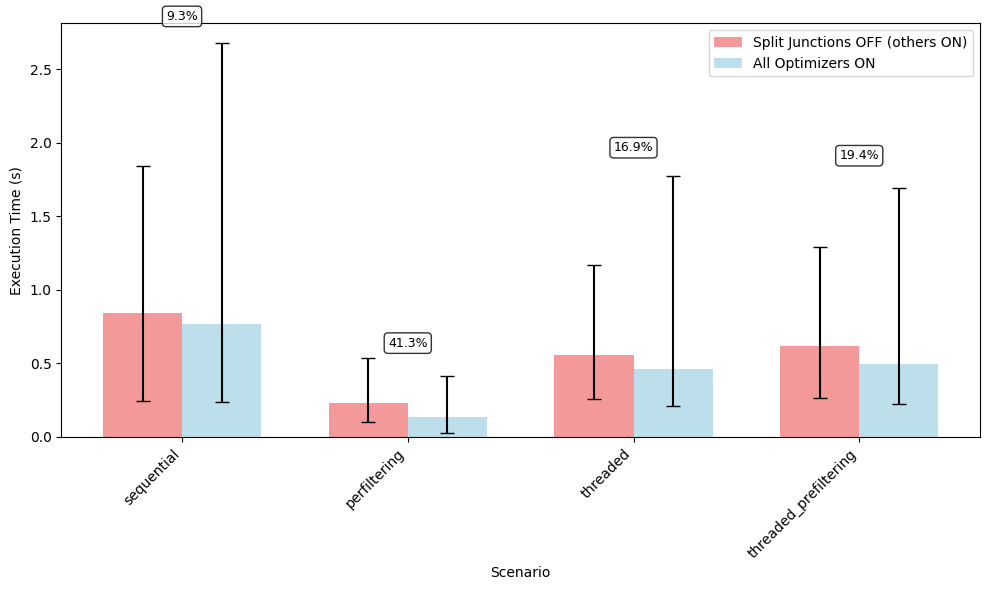

2025-07-19 18:32:29,896 - INFO -   Fainder mode: exact (800 records)
2025-07-19 18:32:29,921 - INFO -     sequential: 13.21% improvement when split junctions ON
2025-07-19 18:32:29,921 - INFO -     perfiltering: 7.01% improvement when split junctions ON
2025-07-19 18:32:29,922 - INFO -     threaded: 12.97% improvement when split junctions ON
2025-07-19 18:32:29,922 - INFO -     threaded_prefiltering: 13.49% improvement when split junctions ON
2025-07-19 18:32:30,000 - INFO -     Saved plot: figures/optimizer/split_junctions_Multiple_Percentile_Combinations_exact.png


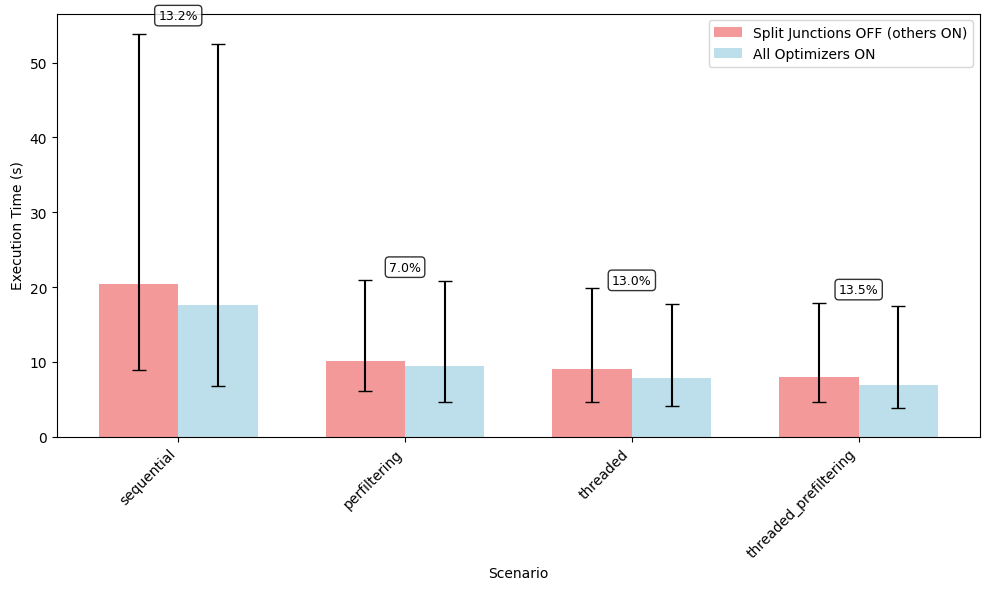

2025-07-19 18:32:30,061 - INFO - Saved split-up junctions statistics to: figures/optimizer/csv_exports/split_junctions_stats_20250719_183228.csv


In [7]:
# ========================================
# SPLIT-UP JUNCTIONS OPTIMIZATION ANALYSIS
# ========================================

logger.info("=== Split-up Junctions Optimization Analysis ===")

# Filter for categories that involve multiple percentile combinations (where junctions matter)
junction_categories = [
    "Multiple_Percentile_Combinations",
]

# Check if optimizer_split_up_junctions column exists
if "optimizer_split_up_junctions" not in df_latest.columns:
    logger.warning(
        "optimizer_split_up_junctions column not found in data - skipping split-up junctions analysis"
    )
else:
    junction_stats = []

    # Filter data for junction-related categories
    df_junctions = df_latest[df_latest["category"].isin(junction_categories)]
    logger.info(f"Found {len(df_junctions)} records for junction-related categories")

    # FILTER: Only include data where all other optimizers are turned ON
    df_junctions_filtered = df_junctions[
        (df_junctions["optimizer_cost_sorting"] == True)
        & (df_junctions["optimizer_keyword_merging"] == True)
    ]
    logger.info(
        f"After filtering for all other optimizers ON: {len(df_junctions_filtered)} records"
    )

    if not df_junctions_filtered.empty:
        # Create comprehensive comparison
        for category in junction_categories:
            df_cat = df_junctions_filtered[
                df_junctions_filtered["category"] == category
            ]
            if df_cat.empty:
                continue

            logger.info(f"Analyzing category: {category} ({len(df_cat)} records)")

            # Create comparison plot for each fainder_mode
            for fainder_mode in df_cat["fainder_mode"].unique():
                df_mode = df_cat[df_cat["fainder_mode"] == fainder_mode]
                if df_mode.empty:
                    continue

                logger.info(f"  Fainder mode: {fainder_mode} ({len(df_mode)} records)")

                # Group by optimizer setting and scenario
                comparison_data = []

                for split_junctions in df_mode["optimizer_split_up_junctions"].unique():
                    df_opt = df_mode[
                        df_mode["optimizer_split_up_junctions"] == split_junctions
                    ]

                    for scenario in df_opt["scenario"].unique():
                        df_scenario = df_opt[df_opt["scenario"] == scenario]

                        if not df_scenario.empty:
                            mean_time = df_scenario["execution_time"].mean()
                            std_time = df_scenario["execution_time"].std()
                            min_time = df_scenario["execution_time"].min()
                            max_time = df_scenario["execution_time"].max()
                            count = len(df_scenario)
                            median_time = df_scenario["execution_time"].median()

                            comparison_data.append(
                                {
                                    "category": category,
                                    "fainder_mode": fainder_mode,
                                    "optimizer_split_up_junctions": split_junctions,
                                    "scenario": scenario,
                                    "mean_execution_time": mean_time,
                                    "median_execution_time": median_time,
                                    "std_execution_time": std_time,
                                    "min_execution_time": min_time,
                                    "max_execution_time": max_time,
                                    "count": count,
                                }
                            )

                            junction_stats.append(
                                {
                                    "category": category,
                                    "fainder_mode": fainder_mode,
                                    "optimizer_split_up_junctions": split_junctions,
                                    "scenario": scenario,
                                    "mean": mean_time,
                                    "median": median_time,
                                    "std": std_time,
                                    "min": min_time,
                                    "max": max_time,
                                    "count": count,
                                }
                            )

                if comparison_data:
                    comparison_df = pd.DataFrame(comparison_data)

                    # Create comparison plot
                    fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))

                    # Bar plot comparison
                    scenarios = comparison_df["scenario"].unique()
                    x = np.arange(len(scenarios))
                    width = 0.35

                    opt_on = comparison_df[
                        comparison_df["optimizer_split_up_junctions"] == True
                    ]
                    opt_off = comparison_df[
                        comparison_df["optimizer_split_up_junctions"] == False
                    ]

                    if not opt_on.empty and not opt_off.empty:
                        # Align data by scenario
                        on_means = [
                            opt_on[opt_on["scenario"] == s]["mean_execution_time"].iloc[
                                0
                            ]
                            if not opt_on[opt_on["scenario"] == s].empty
                            else 0
                            for s in scenarios
                        ]
                        off_means = [
                            opt_off[opt_off["scenario"] == s][
                                "mean_execution_time"
                            ].iloc[0]
                            if not opt_off[opt_off["scenario"] == s].empty
                            else 0
                            for s in scenarios
                        ]

                        on_stds = [
                            opt_on[opt_on["scenario"] == s]["std_execution_time"].iloc[
                                0
                            ]
                            if not opt_on[opt_on["scenario"] == s].empty
                            else 0
                            for s in scenarios
                        ]
                        off_stds = [
                            opt_off[opt_off["scenario"] == s][
                                "std_execution_time"
                            ].iloc[0]
                            if not opt_off[opt_off["scenario"] == s].empty
                            else 0
                            for s in scenarios
                        ]

                        # Get min and max values for error bars
                        off_mins = [
                            opt_off[opt_off["scenario"] == s][
                                "min_execution_time"
                            ].iloc[0]
                            if not opt_off[opt_off["scenario"] == s].empty
                            else 0
                            for s in scenarios
                        ]
                        off_maxs = [
                            opt_off[opt_off["scenario"] == s][
                                "max_execution_time"
                            ].iloc[0]
                            if not opt_off[opt_off["scenario"] == s].empty
                            else 0
                            for s in scenarios
                        ]
                        on_mins = [
                            opt_on[opt_on["scenario"] == s]["min_execution_time"].iloc[
                                0
                            ]
                            if not opt_on[opt_on["scenario"] == s].empty
                            else 0
                            for s in scenarios
                        ]
                        on_maxs = [
                            opt_on[opt_on["scenario"] == s]["max_execution_time"].iloc[
                                0
                            ]
                            if not opt_on[opt_on["scenario"] == s].empty
                            else 0
                            for s in scenarios
                        ]

                        # Calculate error bar arrays (lower_error, upper_error)
                        off_lower_err = [
                            mean - min_val for mean, min_val in zip(off_means, off_mins)
                        ]
                        off_upper_err = [
                            max_val - mean for mean, max_val in zip(off_means, off_maxs)
                        ]
                        on_lower_err = [
                            mean - min_val for mean, min_val in zip(on_means, on_mins)
                        ]
                        on_upper_err = [
                            max_val - mean for mean, max_val in zip(on_means, on_maxs)
                        ]

                        ax1.bar(
                            x - width / 2,
                            off_means,
                            width,
                            label="Split Junctions OFF (others ON)",
                            alpha=0.8,
                            yerr=[off_lower_err, off_upper_err],
                            capsize=5,
                            color="lightcoral",
                        )
                        ax1.bar(
                            x + width / 2,
                            on_means,
                            width,
                            label="All Optimizers ON",
                            alpha=0.8,
                            yerr=[on_lower_err, on_upper_err],
                            capsize=5,
                            color="lightblue",
                        )

                        ax1.set_xlabel("Scenario")
                        ax1.set_ylabel("Execution Time (s)")
                        ax1.set_xticks(x)
                        ax1.set_xticklabels(scenarios, rotation=45, ha="right")
                        ax1.legend()

                        # Add percentage improvement annotations above bars
                        for i, scenario in enumerate(scenarios):
                            if on_means[i] > 0 and off_means[i] > 0:
                                improvement = (
                                    (off_means[i] - on_means[i]) / off_means[i]
                                ) * 100
                                y_pos = (
                                    max(off_means[i], on_means[i])
                                    + max(off_upper_err[i], on_upper_err[i])
                                    + 0.05
                                )
                                ax1.annotate(
                                    f"{improvement:.1f}%",
                                    xy=(x[i], y_pos),
                                    xytext=(0, 3),
                                    textcoords="offset points",
                                    ha="center",
                                    fontsize=9,
                                    bbox=dict(
                                        boxstyle="round,pad=0.3", fc="white", alpha=0.8
                                    ),
                                )
                                logger.info(
                                    f"    {scenario}: {improvement:.2f}% improvement when split junctions ON"
                                )

                        plt.tight_layout()
                        filename = f"figures/optimizer/split_junctions_{category}_{fainder_mode}.png"
                        plt.savefig(filename)
                        logger.info(f"    Saved plot: {filename}")
                        plt.show()
    else:
        logger.warning(
            "No data available for split-up junctions analysis with all other optimizers ON"
        )

    # Save split-up junctions statistics
    if junction_stats:
        junction_stats_df = pd.DataFrame(junction_stats)
        junction_stats_file = csv_dir / f"split_junctions_stats_{timestamp}.csv"
        junction_stats_df.to_csv(junction_stats_file, index=False)
        logger.info(f"Saved split-up junctions statistics to: {junction_stats_file}")

2025-07-19 18:32:30,073 - INFO - === All Optimizations OFF vs ON Comparison (Simple) ===
2025-07-19 18:32:30,076 - INFO - Found 2800 records for all optimization categories
2025-07-19 18:32:30,077 - INFO - Analyzing category: Multiple_Percentile_Combinations (2800 records)
2025-07-19 18:32:30,078 - INFO -   Fainder mode: full_precision (1400 records)
2025-07-19 18:32:30,080 - INFO -     All OFF records: 300
2025-07-19 18:32:30,080 - INFO -     All ON records: 500
2025-07-19 18:32:30,082 - INFO -     sequential: -9.34% improvement (All ON vs All OFF)
2025-07-19 18:32:30,083 - INFO -     perfiltering: 16.99% improvement (All ON vs All OFF)
2025-07-19 18:32:30,084 - INFO -     threaded: -6.62% improvement (All ON vs All OFF)
2025-07-19 18:32:30,085 - INFO -     threaded_prefiltering: -12.76% improvement (All ON vs All OFF)
2025-07-19 18:32:30,418 - INFO -     Saved plot: figures/optimizer/all_optimizations_simple_Multiple_Percentile_Combinations_full_precision.png


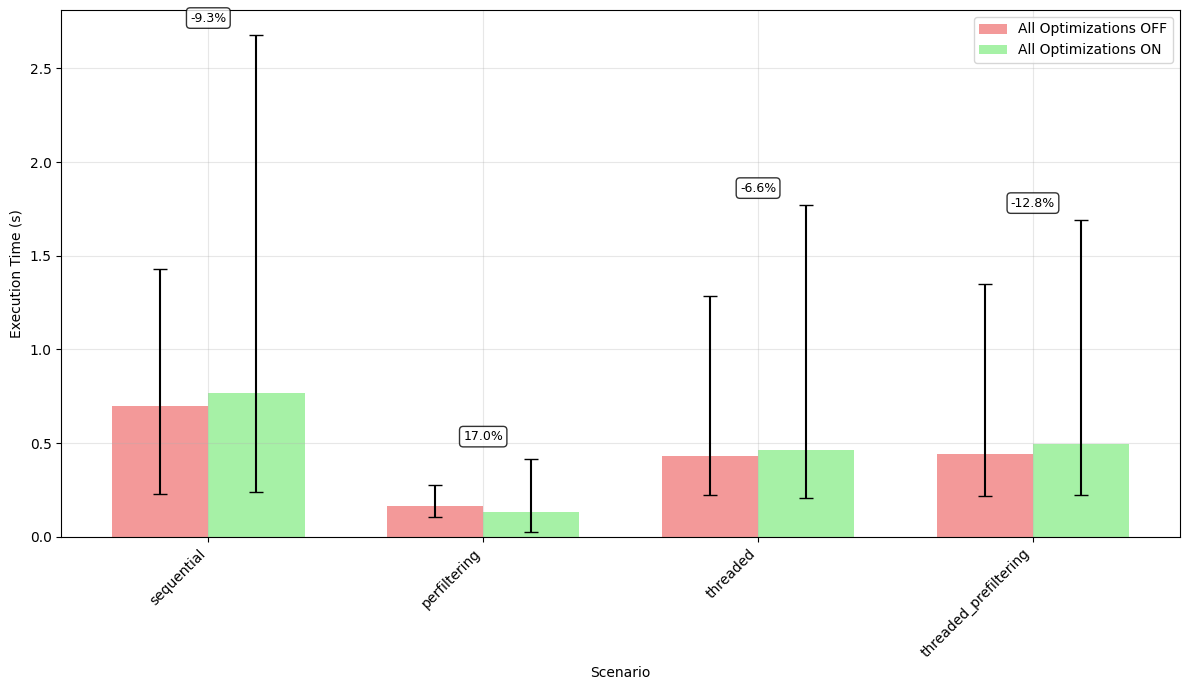

2025-07-19 18:32:30,582 - INFO -     Summary for Multiple_Percentile_Combinations - full_precision:
2025-07-19 18:32:30,582 - INFO -       Average improvement: -2.93%
2025-07-19 18:32:30,583 - INFO -   Fainder mode: exact (1400 records)
2025-07-19 18:32:30,584 - INFO -     All OFF records: 300
2025-07-19 18:32:30,585 - INFO -     All ON records: 500
2025-07-19 18:32:30,586 - INFO -     sequential: 4.87% improvement (All ON vs All OFF)
2025-07-19 18:32:30,587 - INFO -     perfiltering: 3.97% improvement (All ON vs All OFF)
2025-07-19 18:32:30,588 - INFO -     threaded: 9.34% improvement (All ON vs All OFF)
2025-07-19 18:32:30,589 - INFO -     threaded_prefiltering: 5.96% improvement (All ON vs All OFF)
2025-07-19 18:32:30,899 - INFO -     Saved plot: figures/optimizer/all_optimizations_simple_Multiple_Percentile_Combinations_exact.png


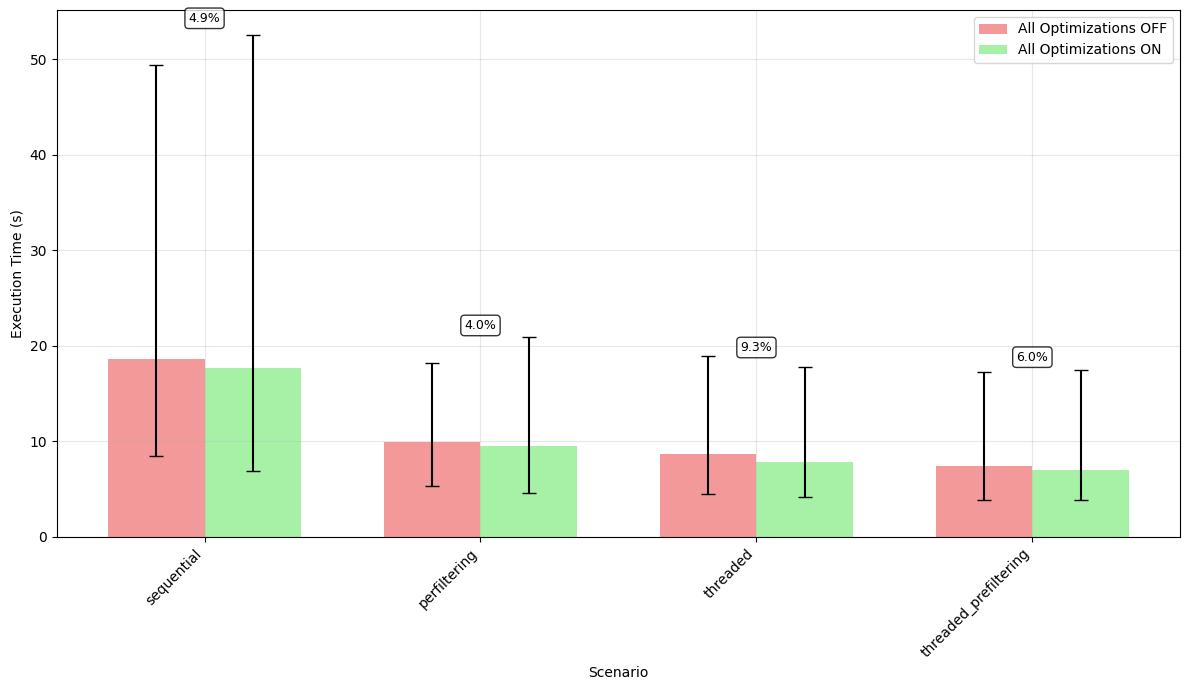

2025-07-19 18:32:30,964 - INFO -     Summary for Multiple_Percentile_Combinations - exact:
2025-07-19 18:32:30,964 - INFO -       Average improvement: 6.04%


In [8]:
# ========================================
# ALL OPTIMIZATIONS OFF vs ON COMPARISON (SIMPLE)
# ========================================

logger.info("=== All Optimizations OFF vs ON Comparison (Simple) ===")

# Categories to analyze for overall optimization impact
all_optimization_categories_simple = [
    "Multiple_Percentile_Combinations",
]

# Check if all optimizer columns exist
required_optimizer_cols = [
    "optimizer_cost_sorting",
    "optimizer_keyword_merging",
    "optimizer_split_up_junctions",
]
missing_cols = [col for col in required_optimizer_cols if col not in df_latest.columns]

if missing_cols:
    logger.warning(
        f"Missing optimizer columns: {missing_cols} - skipping all optimizations comparison"
    )
else:
    # Filter data for relevant categories
    df_all_opt = df_latest[
        df_latest["category"].isin(all_optimization_categories_simple)
    ]
    logger.info(f"Found {len(df_all_opt)} records for all optimization categories")

    if not df_all_opt.empty:
        # Create comprehensive comparison for each category
        for category in all_optimization_categories_simple:
            df_cat = df_all_opt[df_all_opt["category"] == category]
            if df_cat.empty:
                continue

            logger.info(f"Analyzing category: {category} ({len(df_cat)} records)")

            # Create comparison plot for each fainder_mode
            for fainder_mode in df_cat["fainder_mode"].unique():
                df_mode = df_cat[df_cat["fainder_mode"] == fainder_mode]
                if df_mode.empty:
                    continue

                logger.info(f"  Fainder mode: {fainder_mode} ({len(df_mode)} records)")

                # Filter for ALL OFF and ALL ON configurations
                df_all_off = df_mode[
                    (df_mode["optimizer_cost_sorting"] == False)
                    & (df_mode["optimizer_keyword_merging"] == False)
                    & (df_mode["optimizer_split_up_junctions"] == False)
                ]

                df_all_on = df_mode[
                    (df_mode["optimizer_cost_sorting"] == True)
                    & (df_mode["optimizer_keyword_merging"] == True)
                    & (df_mode["optimizer_split_up_junctions"] == True)
                ]

                logger.info(f"    All OFF records: {len(df_all_off)}")
                logger.info(f"    All ON records: {len(df_all_on)}")

                if df_all_off.empty or df_all_on.empty:
                    logger.warning(
                        f"    Missing data for complete comparison in {category} - {fainder_mode}"
                    )
                    continue

                # Group by scenario and collect statistics
                comparison_data = []

                for scenario in df_mode["scenario"].unique():
                    df_scenario_off = df_all_off[df_all_off["scenario"] == scenario]
                    df_scenario_on = df_all_on[df_all_on["scenario"] == scenario]

                    if not df_scenario_off.empty and not df_scenario_on.empty:
                        # All OFF statistics
                        off_mean = df_scenario_off["execution_time"].mean()
                        off_std = df_scenario_off["execution_time"].std()
                        off_min = df_scenario_off["execution_time"].min()
                        off_max = df_scenario_off["execution_time"].max()
                        off_count = len(df_scenario_off)

                        # All ON statistics
                        on_mean = df_scenario_on["execution_time"].mean()
                        on_std = df_scenario_on["execution_time"].std()
                        on_min = df_scenario_on["execution_time"].min()
                        on_max = df_scenario_on["execution_time"].max()
                        on_count = len(df_scenario_on)

                        # Calculate improvement
                        improvement = (
                            ((off_mean - on_mean) / off_mean) * 100
                            if off_mean > 0
                            else 0
                        )

                        comparison_data.append(
                            {
                                "category": category,
                                "fainder_mode": fainder_mode,
                                "scenario": scenario,
                                "all_off_mean": off_mean,
                                "all_off_std": off_std,
                                "all_off_min": off_min,
                                "all_off_max": off_max,
                                "all_off_count": off_count,
                                "all_on_mean": on_mean,
                                "all_on_std": on_std,
                                "all_on_min": on_min,
                                "all_on_max": on_max,
                                "all_on_count": on_count,
                                "improvement_percent": improvement,
                            }
                        )

                        logger.info(
                            f"    {scenario}: {improvement:.2f}% improvement (All ON vs All OFF)"
                        )

                if comparison_data:
                    comparison_df = pd.DataFrame(comparison_data)

                    # Create comparison plot - SIMPLE VERSION (only execution times)
                    fig, ax = plt.subplots(figsize=(12, 7))

                    # Bar plot comparison (execution times)
                    scenarios = comparison_df["scenario"].unique()
                    x = np.arange(len(scenarios))
                    width = 0.35

                    off_means = comparison_df["all_off_mean"].values
                    on_means = comparison_df["all_on_mean"].values

                    off_mins = comparison_df["all_off_min"].values
                    off_maxs = comparison_df["all_off_max"].values
                    on_mins = comparison_df["all_on_min"].values
                    on_maxs = comparison_df["all_on_max"].values

                    # Calculate error bars
                    off_lower_err = off_means - off_mins
                    off_upper_err = off_maxs - off_means
                    on_lower_err = on_means - on_mins
                    on_upper_err = on_maxs - on_means

                    # Add the execution time bars
                    ax.bar(
                        x - width / 2,
                        off_means,
                        width,
                        label="All Optimizations OFF",
                        alpha=0.8,
                        yerr=[off_lower_err, off_upper_err],
                        capsize=5,
                        color="lightcoral",
                    )
                    ax.bar(
                        x + width / 2,
                        on_means,
                        width,
                        label="All Optimizations ON",
                        alpha=0.8,
                        yerr=[on_lower_err, on_upper_err],
                        capsize=5,
                        color="lightgreen",
                    )

                    # Add percentage improvement annotations above bars
                    for i, (off_mean, on_mean) in enumerate(zip(off_means, on_means)):
                        if off_mean > 0 and on_mean > 0:
                            improvement = ((off_mean - on_mean) / off_mean) * 100
                            y_pos = (
                                max(off_mean, on_mean)
                                + max(off_upper_err[i], on_upper_err[i])
                                + 0.05
                            )
                            ax.annotate(
                                f"{improvement:.1f}%",
                                xy=(x[i], y_pos),
                                xytext=(0, 3),
                                textcoords="offset points",
                                ha="center",
                                fontsize=9,
                                bbox=dict(
                                    boxstyle="round,pad=0.3", fc="white", alpha=0.8
                                ),
                            )

                    ax.set_xlabel("Scenario")
                    ax.set_ylabel("Execution Time (s)")
                    ax.set_xticks(x)
                    ax.set_xticklabels(scenarios, rotation=45, ha="right")
                    ax.legend()
                    # ax.set_title(f"All Optimizations OFF vs ON - {category} ({fainder_mode})")
                    ax.grid(True, alpha=0.3)

                    plt.tight_layout()
                    filename = f"figures/optimizer/all_optimizations_simple_{category}_{fainder_mode}.png"
                    plt.savefig(filename, dpi=300, bbox_inches="tight")
                    logger.info(f"    Saved plot: {filename}")
                    plt.show()

                    # Summary statistics
                    avg_improvement = comparison_df["improvement_percent"].mean()
                    logger.info(f"    Summary for {category} - {fainder_mode}:")
                    logger.info(f"      Average improvement: {avg_improvement:.2f}%")
    else:
        logger.warning("No data available for all optimizations comparison (simple)")